In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
datasets_path: str ='../datasets/'
figure_save_path: str ='./figures/'

In [3]:
df_items: pd.DataFrame = pd.read_csv(datasets_path + 'kion_dataset_items.csv')
df_users: pd.DataFrame = pd.read_csv(datasets_path + 'kion_dataset_users.csv')
df_interactions: pd.DataFrame = pd.read_csv(datasets_path + 'kion_dataset_interactions.csv')
holidays: pd.DataFrame = pd.read_excel(datasets_path + 'days_off.xlsx')

In [4]:
holidays['last_watch_dt'] = pd.to_datetime(holidays['last_watch_dt'], format='%Y-%m-%d')
all_df: pd.DataFrame = df_interactions.merge(df_users).merge(df_items)
all_df.index.rename('watch_id', inplace=True)
all_df: pd.DataFrame = all_df.reset_index()
all_df: pd.DataFrame = all_df.drop(columns=['studios', 'Unnamed: 0', 'countries', 'directors', 'actors', 'description', 'keywords', 'watch_id', 'title_orig', 'for_kids'])
df_items['genres_count'] = df_items['genres'].apply(lambda x: len(x.split(',')))
df_items: pd.DataFrame = df_items[df_items['content_type'] == 'film']

all_df: pd.DataFrame = all_df[all_df['watched_pct'].isna() == False]

In [5]:
all_df['last_watch_dt'] = pd.to_datetime(all_df['last_watch_dt'], format='%Y-%m-%d')
all_df['day_week'] = all_df['last_watch_dt'].dt.weekday
all_df: pd.DataFrame = all_df.merge(holidays)
all_df: pd.DataFrame = all_df.drop(columns=['Unnamed: 0'])
all_df: pd.DataFrame = all_df[all_df['content_type'] == 'film']
all_df['genres_count'] = all_df['genres'].apply(lambda x: len(x.split(',')))
all_df['month_of_watch'] = all_df['last_watch_dt'].apply(lambda x: x.month)

In [98]:
for_kids_df = pd.DataFrame(columns = ['month', 'total_dur_sum', 'day_of_week', 'total_dur_pct', 'count_pct'])
no_kids_df = pd.DataFrame(columns = ['month', 'total_dur_sum', 'day_of_week', 'total_dur_pct', 'count_pct'])

days_of_the_week: list[str] = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']
months: dict[int, str] = { 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}
total_dur_months: dict[str, list[int]] = {
    'March': [0, 1, 2, 5, 6],
    'April': [3, 4],
    'May': [0, 5, 6],
    'June': [1, 2],
    'July': [3, 4, 5],
    'August': [6]
}

divide_by_month = {
    'March': 3,
    'April': 5,
    'May': 5,
    'June': 5,
    'July': 5,
    'August': 5
}

def get_data_for_month(all_df: pd.DataFrame, index: int, kids_flag: bool) -> pd.DataFrame:
    return all_df[(all_df['month_of_watch'] == index) & (all_df['kids_flg'] == kids_flag)]

def filter_by_date(data: pd.DataFrame, index: int) -> pd.DataFrame:
    return data[data['day_week'] == index]

def filter_by_content(data: pd.DataFrame) -> pd.DataFrame:
    return round(data[data.age_rating < 13].total_dur.sum() / data.total_dur.sum(), 2)

def get_total_dur_general(all_df: pd.DataFrame, data_by_day: pd.DataFrame, index: str, kids_flag: int) -> int:
    month: str = months[index]
    month_data: list[pd.DataFrame] = [data_by_day[i] for i in total_dur_months[month]]
    total_dur_sum: int = all_df[(all_df['month_of_watch'] == index) & (all_df['kids_flg'] == kids_flag)]['total_dur'].sum()
    return total_dur_sum - sum([month_object.total_dur.sum() / divide_by_month[month] for month_object in month_data])

def count_by_days(data: pd.DataFrame, index: int) -> float:
    return len(data[(data['day_week'] == index) & (data['age_rating'] < 13)]) / len(filter_by_date(data, index))

def filter_main(all_df: pd.DataFrame, month_data: pd.DataFrame, df: pd.DataFrame, index: int, kids_flag: int) -> None:
    data_filtered_by_day: dict[int, pd.DataFrame] = {i: filter_by_date(month_data, i) for i in range(7)}

    total_dur_general: int = get_total_dur_general(all_df, data_filtered_by_day, index, kids_flag)
    total_dur_pct_kids_related: float = month_data.total_dur.sum() / total_dur_general
    
    kids_related_duration_days: dict[int, pd.DataFrame] = {i: filter_by_content(data_filtered_by_day[i]) for i in range(7)}

    kids_related_count: pd.DataFrame = all_df[(all_df['month_of_watch'] == index) & (all_df['kids_flg'] == kids_flag)]
    kids_related_count_days: dict[int, pd.DataFrame] = {i: count_by_days(kids_related_count, i) for i in range(7)}

    for i in range(7):
        df.loc[len(df.index)] = [
            months[index],
            total_dur_pct_kids_related,
            days_of_the_week[i],
            kids_related_duration_days[i],
            kids_related_count_days[i]
        ]

In [99]:
for i in range(3, 9):
    filter_main(all_df, get_data_for_month(all_df, i, True), for_kids_df, i, True)
    filter_main(all_df, get_data_for_month(all_df, i, False), no_kids_df, i, False)

In [105]:
def select_data(data: pd.DataFrame, months: list[str] | None, month: str | None) -> pd.DataFrame:
    if months is not None:
        return pd.concat([data[data.month == month] for month in months])
    elif month is not None:
        return data[data.month == month]
    return data

def bar_plot_plotly(data: pd.DataFrame, y_range: list[float | int]=None, no_y_label: bool = False) -> px.histogram:
    ans = px.histogram(
        data,
        height=720, width=1280,
        x='day_of_week',
        y='total_dur_pct',
        text_auto = True,
        template='simple_white'
    )
    y_label: str = "Доля детского контента" if not no_y_label else ''
    ans.update_layout(font=dict(family="Arial Black", size=20))
    ans.update_traces(textposition='outside', textfont_size=20, marker_color='MediumPurple')
    ans.update_layout(xaxis_title="", yaxis_title=y_label, showlegend=False)
    ans.update_yaxes(range=y_range)
    ans.show()


def bar_plot(
        data: pd.DataFrame,
        title: str,
        months: list[str]=None,
        month: str=None,
        field: str='total_dur_pct',
        save_as: str=None,
        save_path: str='',
        save=True
    ) -> None:
    plt.clf()
    selected_data: pd.DataFrame = select_data(data, months, month)
    x_data: pd.DataFrame = selected_data.day_of_week
    y_data: pd.DataFrame = selected_data[field]
    save_name: str = save_as if save_as is not None else title
    if not os.path.exists(figure_save_path + save_path):
        os.mkdir(figure_save_path + save_path)
    save_path: str = save_path if save_path is None else save_path + '/'
    plt.bar(x=x_data, height=y_data)
    plt.title(title)
    if not save:
        return
    plt.savefig(f'{figure_save_path}{save_path}{save_name.replace(' ', '_')}.jpg')

In [108]:
def get_plotly_dataframe(months: list[str]) -> pd.DataFrame:
    plotly_df: pd.DataFrame = for_kids_df[for_kids_df.month.isin(months)]
    watched_pct_average: list[float] = [round(plotly_df[plotly_df.day_of_week == day].total_dur_pct.sum() / 3, 3) for day in days_of_the_week]
    return pd.DataFrame(index=range(7), data={'total_dur_pct': watched_pct_average, 'day_of_week': days_of_the_week})
bar_plot_plotly(get_plotly_dataframe(['March', 'April', 'May']), y_range=[0, 0.45], no_y_label=True)
bar_plot_plotly(get_plotly_dataframe(['June', 'July', 'August']), y_range=[0, 0.45], no_y_label=True)

In [97]:
for month in months.values():
    bar_plot_plotly(for_kids_df[for_kids_df.month == month], [0, 0.45])

## Общие графики

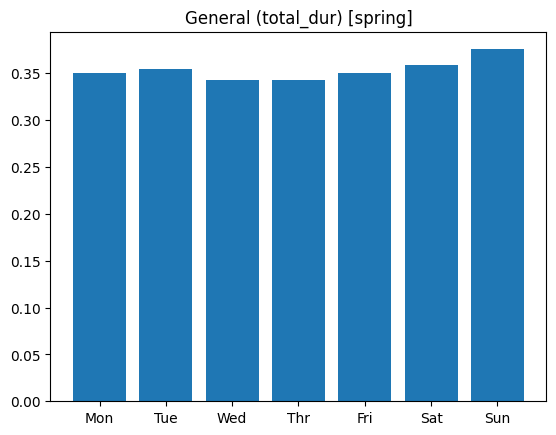

In [13]:
bar_plot(for_kids_df, 'General (total_dur) [spring]', months=['March', 'April', 'May'], save_as='general_total_dur_spring', save_path='general')

(0.0, 0.45)

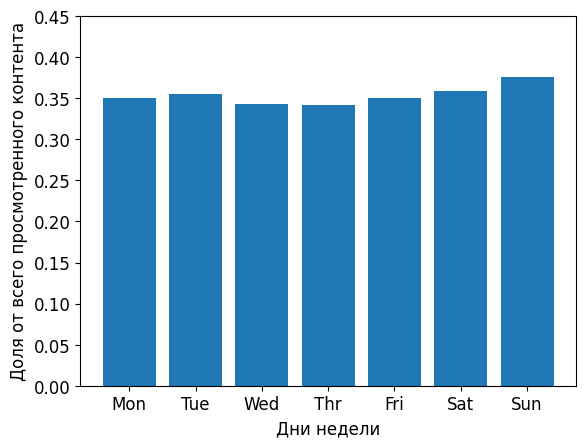

In [14]:
plt.rcParams.update({'font.size': 12})

bar_plot(for_kids_df, '', months=['March', 'April', 'May'], save=False)
plt.xlabel('Дни недели')
plt.ylabel('Доля от всего просмотренного контента')
plt.ylim(top=0.45)

(0.0, 0.45)

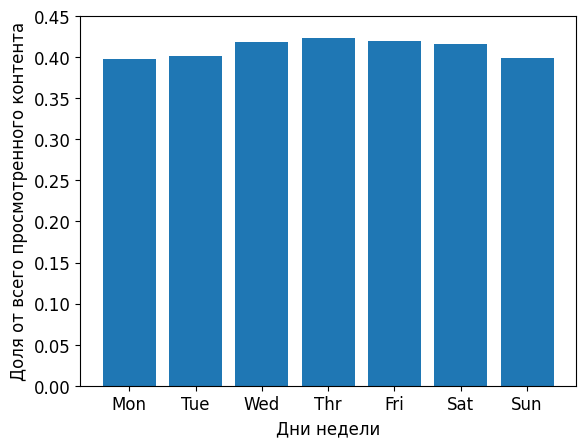

In [15]:
bar_plot(for_kids_df, '', ['June', 'July', 'August'], save=False)
plt.xlabel('Дни недели')
plt.ylabel('Доля от всего просмотренного контента')
plt.ylim(top=0.45)

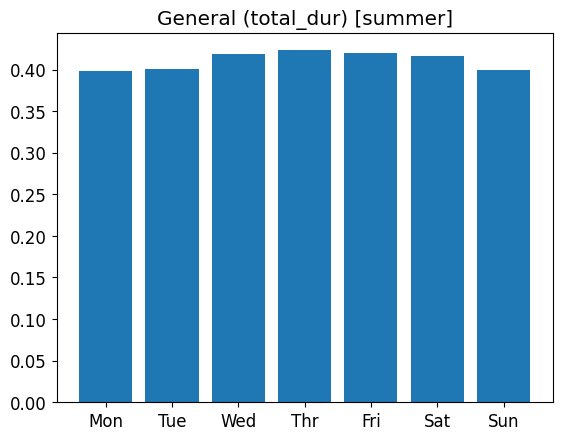

In [16]:
bar_plot(for_kids_df, 'General (total_dur) [summer]', ['June', 'July', 'August'], save_as='general_total_dur_summer', save_path='general')

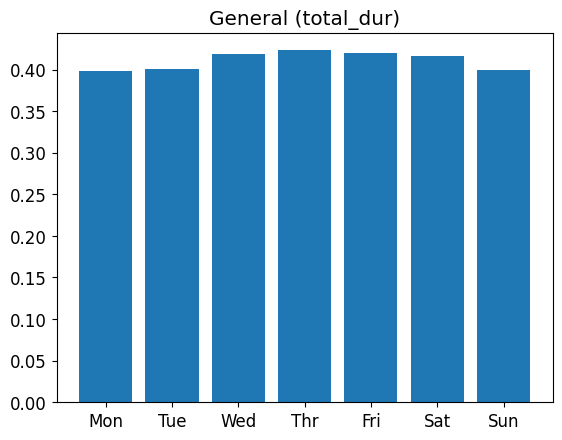

In [17]:
bar_plot(for_kids_df, 'General (total_dur)', save_as='general_total_dur', save_path='general')

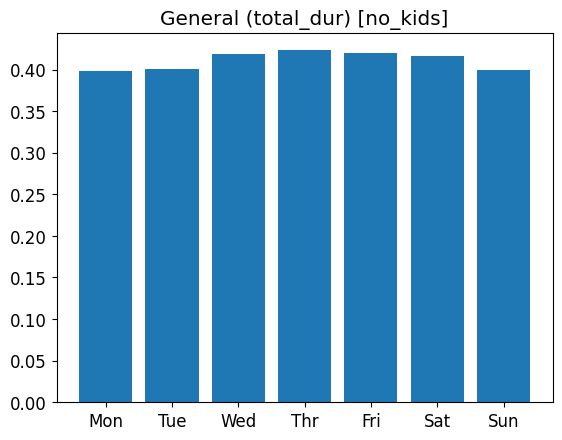

In [18]:
bar_plot(for_kids_df, 'General (total_dur) [no_kids]', field='total_dur_pct', save_as='general_total_dur_no_kids', save_path='general')

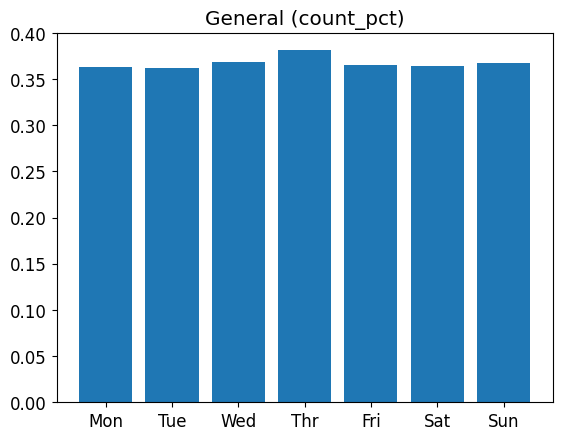

In [19]:
bar_plot(for_kids_df, 'General (count_pct)', field='count_pct', save_as='general_count_pct', save_path='general')

plt.bar(x=no_kids_df['day_of_week'], height=no_kids_df['count_pct'])
plt.title("General (count(pct) [no_kids]")

## Графики распределения просмотра есть/нет детей (перефраз)

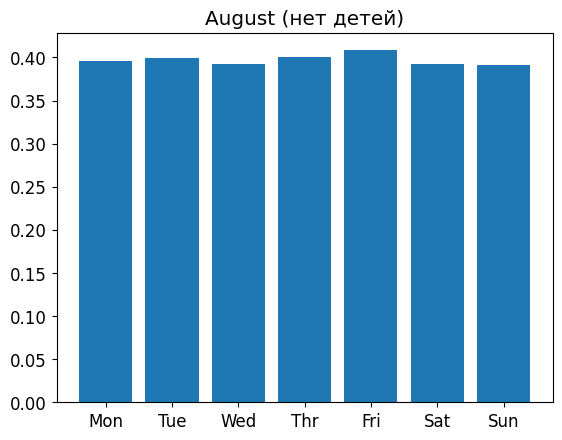

In [20]:
for month in months.values():
    bar_plot(for_kids_df, f'{month} (есть дети)', month=month, save_as=f'{month}_for_kids', save_path='kids')
    bar_plot(no_kids_df, f'{month} (нет детей)', month=month, save_as=f'{month}_no_kids', save_path='no_kids')

## Графики для counts

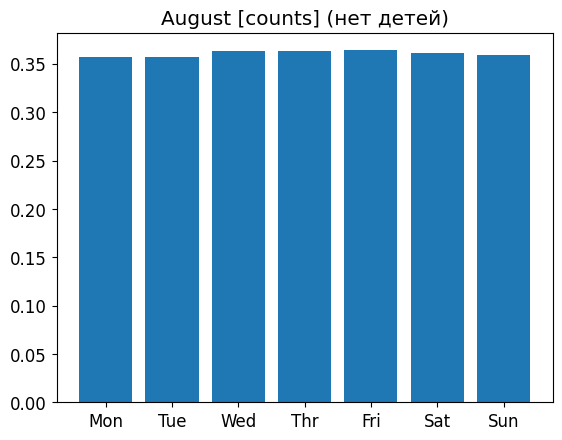

In [21]:
for month in months.values():
    bar_plot(for_kids_df, f'{month} [counts] (есть дети)', month=month, field='count_pct', save_as=f'{month}_for_kids', save_path='counts_kids')
    bar_plot(no_kids_df, f'{month} [counts] (нет детей)', month=month, field='count_pct', save_as=f'{month}_no_kids', save_path='counts_no_kids')